In [1]:
# https://docs.google.com/drawings/d/1jGQbaNEujf4xN86AFFCofBfEyUynqPcrhWJoHZEJS7g/edit
# https://docs.google.com/document/d/1tcfNbqarSxJo81-NWXhdHJWng0gOIC1hSfvz-3in88E/edit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

In [4]:
from oebinarytools.paths import TEST_DATA_DIR
import json
import numpy as np
import pandas as pd

In [5]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [6]:
# get experiment data

In [7]:
experiment_paths = [TEST_DATA_DIR]

In [8]:
def retrive_experiments(experiment_paths):
    """ Grab all experiments from paths
    """
    all_dat_files = []
    all_info_files = []
    all_recording_message_files = []
    for experiment_loc in experiment_paths:
        dat_files = list(experiment_loc.glob('**/*.dat'))
        info_files = list(experiment_loc.glob('**/structure.oebin'))
        recording_message_files = list(experiment_loc.glob('**/sync_messages.txt'))
        all_dat_files += dat_files
        all_info_files += info_files
        all_recording_message_files += recording_message_files
    return all_dat_files, all_info_files, all_recording_message_files

In [9]:
TEST_DATA_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357')

In [10]:
dat_files, info_files, sync_files = retrive_experiments(experiment_paths)
dat_files

[PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/continuous/Rhythm_FPGA-105.0/continuous.dat'),
 PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording2/continuous/Rhythm_FPGA-105.0/continuous.dat'),
 PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment1/recording1/continuous/Rhythm_FPGA-105.0/continuous.dat')]

In [11]:
def get_recording_ttl_events(dat_file, FPGA_events_folder):
    """ load and grab FPGA TTL events from corresponding dat file
    """
    FPGA_events = dat_file.parent.parent.parent / 'events' / FPGA_events_folder
    channel_states = np.load(FPGA_events / 'channel_states.npy')
    channels = np.load(FPGA_events / 'channels.npy')
    full_words = np.load(FPGA_events / 'full_words.npy')
    timestamps = np.load(FPGA_events / 'timestamps.npy')
    
    TTL_events = pd.DataFrame(
        {
            "channels": channels,
            "channel_states": channel_states,
            "timestamps": timestamps,
            "full_words": full_words,
        }
    )
    return TTL_events

In [12]:
def parse_Network_Events(recording):
    """ goes through Network Events folder and grabs all relevant data
    """
    # search through recording for network events
    network_events_dfs = []
    for event_folder in recording["info"]["events"]:
        if "Network_Events" in event_folder["folder_name"]:
            if "TEXT_group" in event_folder["folder_name"]:

                # load text and timestamp events
                zmq_text_events_folter = (
                    recording["dat_file"].parents[2]
                    / "events"
                    / event_folder["folder_name"]
                )
                channels = np.load(zmq_text_events_folter / 'channels.npy')
                metadata = np.load(zmq_text_events_folter / 'metadata.npy')
                text = np.load(zmq_text_events_folter / 'text.npy')
                timestamps = np.load(zmq_text_events_folter / 'timestamps.npy')

                network_events_df = pd.DataFrame(
                    {
                        "channels": channels,
                        "metadata": metadata,
                        "text": text.astype('str'),
                        "timestamps": timestamps,
                    }
                )
                network_events_dfs.append(network_events_df)
    if len(network_events_dfs) > 0:
        return pd.concat(network_events_dfs)

In [13]:
def find_first_peak(data, thresh_factor=0.3):
    """ Find the first peak in a sine wave 
        Originally by Zeke Arneodo
    """
    data = data - np.mean(data)
    thresh = np.max(data) * thresh_factor
    a = data[1:-1] - data[2:]
    b = data[1:-1] - data[:-2]
    c = data[1:-1]
    max_pos = np.where((a >= 0) & (b > 0) & (c > thresh))[0] + 1
    return int(max_pos[0])


def detect_audio_events(
    recording, sine_channel_num=None, audio_binary_channel_num=None, signal_pad_s=0.1
):
    """ Find audio events given a sine channel and an audio onset/offset signal
    """

    # get recording info
    dat_file = recording["dat_file"]
    sample_rate = recording["info"]["continuous"][0]["sample_rate"]
    num_channels = recording["info"]["continuous"][0]["num_channels"]

    # load recording data into spikeinterface
    recording_si = se.BinDatRecordingExtractor(
        dat_file, sampling_frequency=sample_rate, numchan=num_channels, dtype="int16"
    )

    # assume sine channel is first ADC channel
    if sine_channel_num is None:
        sine_channel_num = recording["ADC_data_channels"][0]
    # assume audio binary channel is third ADC channel
    if audio_binary_channel_num is None:
        audio_binary_channel_num = recording["ADC_data_channels"][2]

    # get sine channel
    sine_channel = recording_si.get_traces()[sine_channel_num]
    # get audio_on channel
    audio_on_channel = recording_si.get_traces()[audio_binary_channel_num]
    # make binary
    audio_on_channel_binary = audio_on_channel / np.max(audio_on_channel) > 0.1

    # get starts and ends of playback
    audio_starts = np.where(
        (audio_on_channel_binary[:-1] == 0) & (audio_on_channel_binary[1:] == 1)
    )[0]
    audio_stops = np.where(
        (audio_on_channel_binary[:-1] == 1) & (audio_on_channel_binary[1:] == 0)
    )[0]
    # set equal, in case we begin or end in the middle of a playback
    audio_stops = audio_stops[-len(audio_starts) :]
    audio_starts = audio_starts[: len(audio_stops)]

    # sync audio playback with sine channel
    signal_pad_frames = signal_pad_s * sample_rate

    # get where the sine wave begins in that region
    start_frames = np.zeros(len(audio_starts))
    end_frames = np.zeros(len(audio_stops))
    # get sine beginning and ending
    for playback_i, (start, stop) in enumerate(zip(audio_starts, audio_stops)):
        window_start = start + signal_pad_frames
        window_end = stop - signal_pad_frames
        window = sine_channel[int(window_start) : int(window_end)]
        fp = find_first_peak(window) + window_start
        lp = len(window) - find_first_peak(window[::-1]) + window_start
        start_frames[playback_i] = fp
        end_frames[playback_i] = lp

    playback_df = pd.DataFrame(
        {"timestamp_begin": start_frames, "timestamp_end": end_frames}
    )

    return playback_df

In [14]:
def create_recordings_dict(dat_files, info_files, sync_files):
    """ create a dictionary of all recordings and parameters
    """

    recordings = {}
    for ri, (dat_file, info_file, sync_file) in enumerate(
        zip(dat_files, info_files, sync_files)
    ):
        #
        recordings[ri] = {
            "dat_file": dat_file,
            "info_file": info_file,
            "sync_file": sync_file,
        }

        # add info from .oebin
        info = open(info_file.as_posix()).read()
        recordings[ri]["info"] = json.loads(info)

        # add sync messages
        sync_message = open(sync_file.as_posix()).read()
        recordings[ri]["sync_message"] = sync_message

        # grab TTL events from FPGA events folder
        FPGA_events_folder = recordings[ri]["info"]["events"][0]["folder_name"]
        recordings[ri]["FPGA_events"] = get_recording_ttl_events(
            dat_file, FPGA_events_folder
        )

        # specify neural data channels
        channel_desc = recordings[ri]["info"]["continuous"][0]["channels"]
        recordings[ri]["neural_data_channels"] = [
            i["source_processor_index"]
            for i in channel_desc
            if i["description"] == "Headstage data channel"
        ]
        recordings[ri]["AUX_data_channels"] = [
            i["source_processor_index"]
            for i in channel_desc
            if i["description"] == "Auxiliar data channel"
        ]
        
        recordings[ri]["ADC_data_channels"] = [
            i["source_processor_index"]
            for i in channel_desc
            if i["description"] == "ADC data channel"
        ]
        
        # parse network events for each recording
        recordings[ri]['network_events'] = parse_Network_Events(recordings[ri])
        
        recordings[ri]['audio_events'] = detect_audio_events(recordings[ri])
        
    return recordings

In [15]:
recordings = create_recordings_dict(dat_files, info_files, sync_files)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/structure.oebin' mode='r' encoding='UTF-8'>
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/sync_messages.txt' mode='r' encoding='UTF-8'>
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording2/structure.oebin' mode='r' encoding

In [16]:
recordings[0]

{'dat_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/continuous/Rhythm_FPGA-105.0/continuous.dat'),
 'info_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/structure.oebin'),
 'sync_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/sync_messages.txt'),
 'info': {'GUI version': '0.5.0',
  'continuous': [{'folder_name': 'Rhythm_FPGA-105.0/',
    'sample_rate': 30000,
    'source_processor_name': 'Rhythm FPGA',
    'source_processor_id': 105,
    'source_processor_sub_idx': 0,
    'recorded_processor': 'Record Node',
    'recorded_processor_id': 110,
    'num_channels': 43,
    'channels': [{'channel_name': 'CH1',
      'description': 'Headstage 

In [17]:
ri=0
recording = recordings[ri]

In [18]:
dat_file = recording['dat_file']
sample_rate = recording['info']['continuous'][0]['sample_rate']
num_channels = recording['info']['continuous'][0]['num_channels']

In [19]:
recording_si = se.BinDatRecordingExtractor(
    dat_file, sampling_frequency=sample_rate, numchan=num_channels, dtype="int16"
)

In [20]:
recording['ADC_data_channels']

[35, 36, 37, 38, 39, 40, 41, 42]

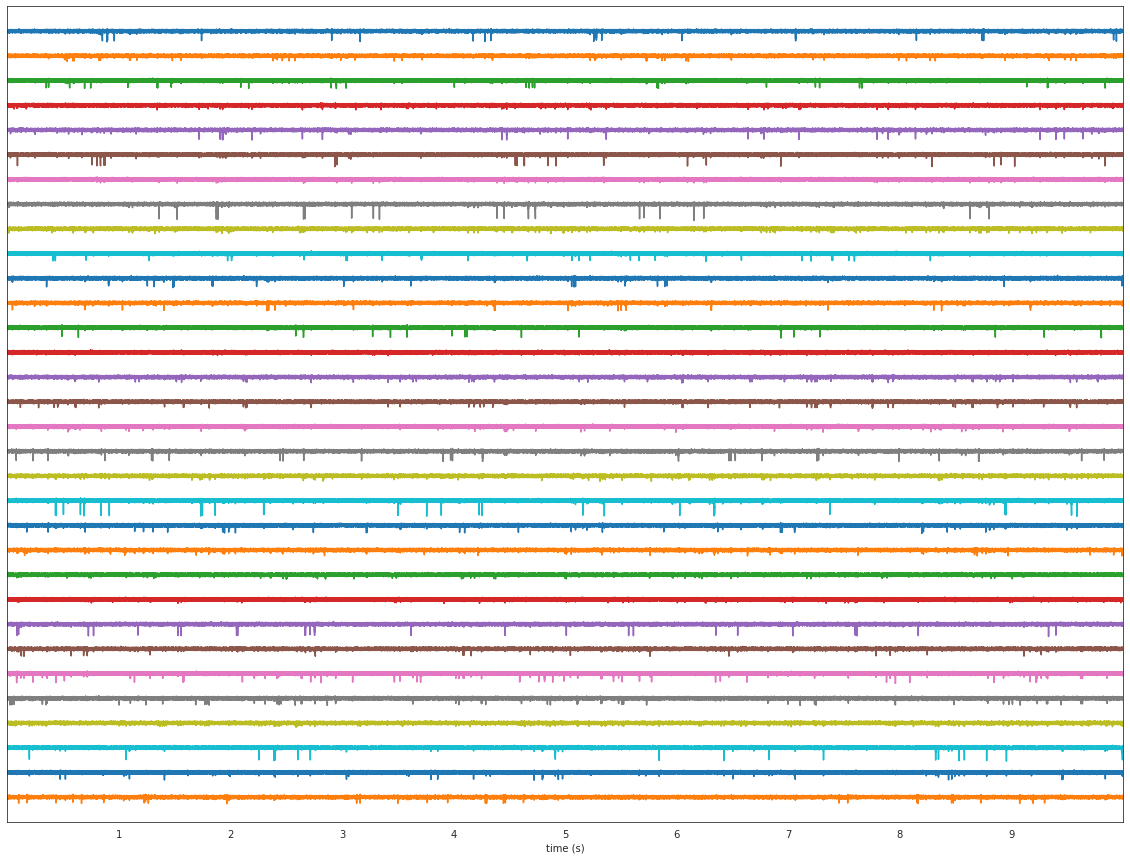

In [21]:
t_range = [0, 10]
channels = list(np.arange(1, 38))
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize=(20,15))
ts_raw = sw.plot_timeseries(recording_si, channel_ids=recording['neural_data_channels'], trange=t_range, ax = ax)

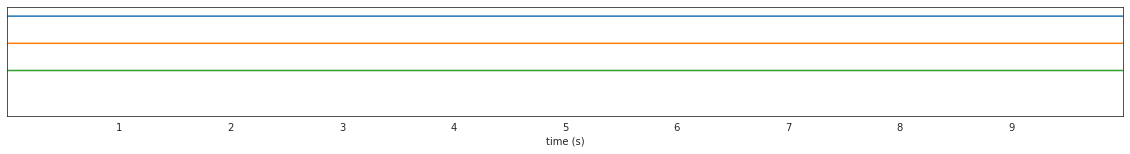

In [22]:
t_range = [0, 10]
channels = list(np.arange(1, 38))
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize=(20,2))
ts_raw = sw.plot_timeseries(recording_si, channel_ids=recording['AUX_data_channels'], trange=t_range, ax = ax)

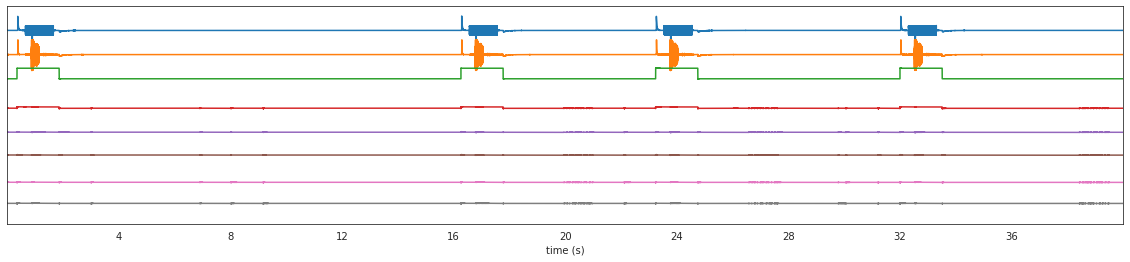

In [26]:
t_range = [0, 40]
channels = list(np.arange(1, 38))
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize=(20,4))
ts_raw = sw.plot_timeseries(recording_si, channel_ids=recording['ADC_data_channels'], trange=t_range, ax = ax)

In [24]:
# get recording ADC_data_channels

In [25]:
recording

{'dat_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/continuous/Rhythm_FPGA-105.0/continuous.dat'),
 'info_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/structure.oebin'),
 'sync_file': PosixPath('/mnt/cube/tsainbur/Projects/github_repos/oebinarytools/oebinarytools/test_dataset/B7357/2020-10-16_13-21-53/Record Node 110/experiment2/recording1/sync_messages.txt'),
 'info': {'GUI version': '0.5.0',
  'continuous': [{'folder_name': 'Rhythm_FPGA-105.0/',
    'sample_rate': 30000,
    'source_processor_name': 'Rhythm FPGA',
    'source_processor_id': 105,
    'source_processor_sub_idx': 0,
    'recorded_processor': 'Record Node',
    'recorded_processor_id': 110,
    'num_channels': 43,
    'channels': [{'channel_name': 'CH1',
      'description': 'Headstage 

### TODO

#### trialization
- segment audio based upon ADC channel + network events
- merge network events with audio
- merge network events with TTL
- save event * event ID * timestamp (begin + end) 

#### spike sorting
- sort spikes
- df of spikes * cluster * timestamp df
- create dataframe of clusters * type * channels * # spikes

#### plotting
- plot clusters 
- plot audio relative to spike rasters